<a href="https://colab.research.google.com/github/AshwinUniyal/ML_Project/blob/main/ML_Coursework_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. tabular dataset

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
label_encoder = preprocessing.LabelEncoder()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df = pd.read_csv("/content/drive/MyDrive/fars_data/fars.csv")

In [ ]:
#!pip install pandas_profiling -U

In [ ]:
import pandas_profiling as pp

profile = pp.ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Data Analysis

# Data preprocessing
### Checking and removing duplicates

In [13]:
print('Total number of observations/rows: ',df.shape[0])
dup_rows = df.duplicated(keep = 'first')
print('Number of duplicate rows: ',dup_rows.sum())
df = df.drop_duplicates()
print('Number of rows left after removing duplicates: ',df.shape[0])
print('Shape of data: ', df.shape)

Total number of observations/rows:  100968
Number of duplicate rows:  7964
Number of rows left after removing duplicates:  93004
Shape of data:  (93004, 30)


## proof high correlation and drop columns like ejection and ejection path 

2. non motorist is not applicable in most cases, so dropping

3. dropping one injury category because of only 6 such incidents , died prior accident

In [208]:
# Class imbalance correction
# dropping a class having only 9 observation and
# mergin almost identical 3 classes where injury severity is unknown
df.INJURY_SEVERITY.replace(['Unknown', 'Injured_Severity_Unknown'], 'Possible_Injury', inplace=True) # merge classes
df = df[df.INJURY_SEVERITY != 'Died_Prior_to_Accident'] # drop class

In [37]:
df = df.drop(['EJECTION_PATH','NON_MOTORIST_LOCATION','METHOD_ALCOHOL_DETERMINATION',
       'ALCOHOL_TEST_TYPE','METHOD_OF_DRUG_DETERMINATION',
       'DRUG_TEST_TYPE','DRUG_TEST_TYPE_(2_of_3)', 'DRUG_TEST_RESULTS_(2_of_3)',
       'DRUG_TEST_TYPE_(3_of_3)', 'DRUG_TEST_RESULTS_(3_of_3)','HISPANIC_ORIGIN', 'RELATED_FACTOR_(1)-PERSON_LEVEL', 'RELATED_FACTOR_(2)-PERSON_LEVEL',
       'RELATED_FACTOR_(3)-PERSON_LEVEL', 'RACE'], axis=1)

In [209]:
df = df.drop(['EJECTION_PATH','NON_MOTORIST_LOCATION','METHOD_ALCOHOL_DETERMINATION',
       'ALCOHOL_TEST_TYPE','METHOD_OF_DRUG_DETERMINATION', 'DRUG_TEST_RESULTS_(2_of_3)', 'DRUG_TEST_RESULTS_(3_of_3)','HISPANIC_ORIGIN', 'RELATED_FACTOR_(1)-PERSON_LEVEL'], axis=1)

In [210]:
bins = [0,18, 35, 65, 100]
names = [0, 1, 2,3]

df['AgeRange'] = pd.cut(df['AGE'], bins, labels=names)
df['AgeRange'] = df['AgeRange'].fillna(0)
df['AgeRange'] = df['AgeRange'].astype('int')
df = df.drop(['AGE'], axis=1)

In [211]:
bins = [0,3, 900,1000]
names = [0, 1, 2]

df['DRUG_TEST_RESULTS_(1_of_3)'] = pd.cut(df['DRUG_TEST_RESULTS_(1_of_3)'], bins, labels=names)
df['DRUG_TEST_RESULTS_(1_of_3)'] = df['DRUG_TEST_RESULTS_(1_of_3)'].fillna(0)
df['DRUG_TEST_RESULTS_(1_of_3)'] = df['DRUG_TEST_RESULTS_(1_of_3)'].astype('int')

In [ ]:
bins = [0,2, 35, 95, 100]
names = [0, 1, 2,3]

df['ALCOHOL_TEST_RESULT'] = pd.cut(df['ALCOHOL_TEST_RESULT'], bins, labels=names)
df['ALCOHOL_TEST_RESULT'] = df['ALCOHOL_TEST_RESULT'].fillna(0)
df['ALCOHOL_TEST_RESULT'] = df['ALCOHOL_TEST_RESULT'].astype('int')

In [38]:
# mapping top 6 positions and remaining ones as a group
df['SEATING_POSITION'] = df['SEATING_POSITION'].map({'Front_Seat_-_Left_Side_(Drivers_Side)':0,'Front_Seat_-_Right_Side':1,'Non-Motorist':2,'Second_Seat_-_Right_Side':3,'Second_Seat_-_Left_Side':4,'Second_Seat_-_Middle':5,'Unknown':6,'Other_Passenger_in_enclosed_passenger_or_cargo_area':7,'Front_Seat_-_Middle':7,'Other_Passenger_in_unenclosed_passenger_or_cargo_area':7,'Second_Seat_-_Unknown':7,'Third_Seat_-_Left_Side_(Drivers_Side)':7,'Third_Seat_-_Right_Side':7,'Sleeper_Section_of_Cab_(Truck)':7,'Third_Seat_-_Middle':7,'Third_Seat_-_Unknown':7,'Riding_on_Vehicle_Exterior':7,'Second_Seat_-_Other':7,'Other_Passenger_in_passenger_or_cargo_area_(unknown_whether_or_not_enclosed)':7,'Front_Seat_-_Unknown':7,'Front_Seat_-_Other':7,'Trailing_Unit':7,'Third_Seat_-_Other':7,'Fourth_Seat_-_Left_Side':7,'Fourth_Seat_-_Right_Side':7,'Fourth_Seat_-_Middle':7})
df['SEATING_POSITION']

0         0
1         0
2         0
3         1
4         0
         ..
100963    4
100964    3
100965    5
100966    5
100967    0
Name: SEATING_POSITION, Length: 100959, dtype: int64

Merging low freq categories

In [212]:
obj_columns = list(df.select_dtypes(include=['object']).columns)    # Get a list of all the columns' names with object dtype
obj_columns.remove('INJURY_SEVERITY') 

In [213]:
threshold = 300
df = df.apply(lambda x: x.mask(x.map(x.value_counts())<threshold, 'less_freq') if x.name in obj_columns else x)

In [214]:
df_encoded = pd.get_dummies(data=df, columns=obj_columns)
df_encoded.dtypes

ALCOHOL_TEST_RESULT                      int64
DRUG_TEST_RESULTS_(1_of_3)               int64
INJURY_SEVERITY                         object
AgeRange                                 int64
CASE_STATE_Alabama                       uint8
                                         ...  
RACE_Black                               uint8
RACE_Not_a_Fatality_(Not_Applicable)     uint8
RACE_Unknown                             uint8
RACE_White                               uint8
RACE_less_freq                           uint8
Length: 131, dtype: object

In [215]:
df_encoded.shape

(92995, 131)

In [39]:
# label_encoder = preprocessing.LabelEncoder()

# df['SEX'] = label_encoder.fit_transform(df['SEX'])
# df['CASE_STATE'] = label_encoder.fit_transform(df['CASE_STATE'])
# df['PERSON_TYPE'] = label_encoder.fit_transform(df['PERSON_TYPE'])
# df['RESTRAINT_SYSTEM-USE'] = label_encoder.fit_transform(df['RESTRAINT_SYSTEM-USE'])
# df['AIR_BAG_AVAILABILITY/DEPLOYMENT'] = label_encoder.fit_transform(df['AIR_BAG_AVAILABILITY/DEPLOYMENT'])
# df['EJECTION'] = label_encoder.fit_transform(df['EJECTION'])
# df['EXTRICATION'] = label_encoder.fit_transform(df['EXTRICATION'])
# df['POLICE_REPORTED_ALCOHOL_INVOLVEMENT'] = label_encoder.fit_transform(df['POLICE_REPORTED_ALCOHOL_INVOLVEMENT'])
# df['POLICE-REPORTED_DRUG_INVOLVEMENT'] = label_encoder.fit_transform(df['POLICE-REPORTED_DRUG_INVOLVEMENT'])
# df['TAKEN_TO_HOSPITAL'] = label_encoder.fit_transform(df['TAKEN_TO_HOSPITAL'])

# df['DRUG_TEST_RESULTS_(1_of_3)']= label_encoder.fit_transform(df['DRUG_TEST_RESULTS_(1_of_3)'])
# df['ALCOHOL_TEST_RESULT'] = label_encoder.fit_transform(df['ALCOHOL_TEST_RESULT'])



In [216]:

df_encoded['INJURY_SEVERITY'].value_counts()

Fatal_Injury                      41442
No_Injury                         15642
Incapaciting_Injury               14230
Nonincapaciting_Evident_Injury    12945
Possible_Injury                    8736
Name: INJURY_SEVERITY, dtype: int64

In [217]:
df_encoded['INJURY_SEVERITY']= label_encoder.fit_transform(df_encoded['INJURY_SEVERITY'])

In [189]:
df_encoded.head()

ALCOHOL_TEST_RESULT  DRUG_TEST_RESULTS_(1_of_3)      INJURY_SEVERITY  \
0                   97                         999         Fatal_Injury   
1                   96                           0         Fatal_Injury   
2                   96                           0         Fatal_Injury   
3                   96                           0  Incapaciting_Injury   
4                   97                         999         Fatal_Injury   

   AgeRange  CASE_STATE_Alabama  CASE_STATE_Arizona  CASE_STATE_Arkansas  \
0         1                   1                   0                    0   
1         1                   1                   0                    0   
2         2                   1                   0                    0   
3         2                   1                   0                    0   
4         2                   1                   0                    0   

   CASE_STATE_California  CASE_STATE_Colorado  CASE_STATE_Connecticut  ...  \
0                      0                    0                       0  ...   
1                      0                    0                       0  ...   
2                      0                    0                       0  ...   
3                      0                    0                       0  ...   
4                      0                    0                       0  ...   

   RELATED_FACTOR_(2)-PERSON_LEVEL_Not_Applicable_-_Driver/None_-_All_Other_Persons  \
0                                                  1                                  
1                                                  1                                  
2                                                  1                                  
3                                                  1                                  
4                                                  1                                  

   RELATED_FACTOR_(2)-PERSON_LEVEL_less_freq  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   RELATED_FACTOR_(3)-PERSON_LEVEL_Not_Applicable_-_Driver/None_-_All_Other_Persons  \
0                                                  1                                  
1                                                  1                                  
2                                                  1                                  
3                                                  1                                  
4                                                  1                                  

   RELATED_FACTOR_(3)-PERSON_LEVEL_less_freq  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   RACE_American_Indian_(_Includes_Aleuts_and_Eskimos)  RACE_Black  \
0                                                  0             0   
1                                                  0             0   
2                                                  0             1   
3                                                  0             0   
4                                                  0             1   

   RACE_Not_a_Fatality_(Not_Applicable)  RACE_Unknown  RACE_White  \
0                                     0             0           1   
1                                     0             0           1   
2                                     0             0           0   
3                                     1             0           0   
4                                     0             0           0   

   RACE_less_freq  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 131 columns]

### checking freq of classes

### under / over sampling may be required 

Get Input X and Output Y

In [218]:
X = df_encoded.loc[:, df_encoded.columns != 'INJURY_SEVERITY']
y = df_encoded.loc[:, df_encoded.columns == 'INJURY_SEVERITY']
print(X.shape)
print(y.shape)

(92995, 130)
(92995, 1)


## Scaling the inputs

In [219]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [16]:
X

array([[-0.12323565,  0.72022438,  1.96682285, ..., -0.48421973,
         1.94523508, -0.07599611],
       [-0.78020415,  0.69700774, -0.53334191, ..., -0.48421973,
         1.94523508, -0.07599611],
       [ 0.29910124,  0.69700774, -0.53334191, ..., -0.48421973,
        -0.51407669, -0.07599611],
       ...,
       [-1.39024632,  0.69700774, -0.53334191, ..., -0.48421973,
        -0.51407669, -0.07599611],
       [-1.53102528,  0.69700774, -0.53334191, ..., -0.48421973,
        -0.51407669, -0.07599611],
       [ 1.14377502,  0.69700774, -0.53334191, ..., -0.48421973,
         1.94523508, -0.07599611]])

Splitting Train, Text, Val set

In [220]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=1, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.11, random_state=1)


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(74488, 130)
(9300, 130)
(9207, 130)
(74488, 1)


In [221]:
y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

SMOTE

In [23]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train.values)

In [29]:
unique, counts = np.unique(y_train_smote, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 29082]
 [    1 29082]
 [    2 29082]
 [    3 29082]
 [    4 29082]]


In [31]:
y_train_smote = y_train_smote.flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [39]:
np.asarray(y_train_smote)

array([0, 0, 1, ..., 4, 4, 4])

Adjusting class weight

In [82]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)

In [83]:
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.44792655250670516,
 1: 1.3029205841168234,
 2: 1.1945529573590097,
 3: 1.4432306669621096,
 4: 2.1278340411630188}

# Making predictive model
## logistic regression

In [222]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0, max_iter = 1000)

In [223]:
logreg.fit(X_train,y_train)
print('Accuracy of classifier on training set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of classifier on training set: 0.8015
Accuracy of Decision tree classifier on test set: 0.8033


In [ ]:
logreg.coef_

In [ ]:
# optimising LogReg
from sklearn.model_selection import GridSearchCV

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,5,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = GridSearchCV(estimator=LogisticRegression(max_iter = 750), param_grid=parameters, cv= 5, verbose = 2, return_train_score=True)
logreg.fit(X_train, y_train)

In [ ]:
logreg.best_estimator_

In [1]:
logreg.best_score_

NameError: ignored

In [ ]:
logreg.score(X_test, y_test)

tf.keras.utils.plot_model(model)

## Stacking

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

estimators = [
  ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr',LinearSVC(random_state=42))]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression(multi_class='multinomial', solver='lbfgs')
 )

clf.fit(X_train, y_train).score(X_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

0.8059139784946237

In [16]:
clf.score(X_test,y_test)


0.8059139784946237

In [17]:
clf.score(X_val,y_val)

0.7978711849679592

## decision tree

In [225]:
from sklearn.tree import DecisionTreeClassifier
DTclf_model = DecisionTreeClassifier(criterion="gini", random_state=1,max_depth=5, min_samples_leaf=1)   
DTclf_model.fit(X_train,y_train)

y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.7768
Accuracy of Decision tree classifier on test set: 0.7802


optimising Decision tree

In [153]:
parameters = {'max_leaf_nodes': [10, 30, 40], 
          'min_samples_split': [2,3,4, 6],
          
          'max_depth':[8,13]}

DTclf_model = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv= 5, verbose = 2, return_train_score = True)
DTclf_model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=2; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=2; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=2; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=2; total time=   0.4s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=2; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=3; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=3; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=3; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=3; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=3; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_samples_split=4; total time=   0.5s
[CV] END max_depth=8, max_leaf_nodes=10, min_sa

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [8, 13], 'max_leaf_nodes': [10, 30, 40],
                         'min_samples_split': [2, 3, 4, 6]},
             return_train_score=True, verbose=2)

In [154]:
DTclf_model.best_estimator_

DecisionTreeClassifier(max_depth=13, max_leaf_nodes=30)

In [155]:
DTclf_model.best_score_

0.7931807503859319

In [156]:
DTclf_model.score(X_test,y_test)

0.7913127620685948

Accuracy improved from 77.6 to 79.5

# Random forest

In [226]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, max_leaf_nodes=None,min_samples_split=2)  
rf_clf.fit(X_train,y_train)
score = rf_clf.score(X_test, y_test)
print(score)

0.7964516129032259


Optimising random forest

In [228]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [5,7],
    'max_features': [ 'sqrt', 'log2']
}

rf_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, verbose = 2)
rf_clf.fit(X_train, y_train)

# print best parameter after tuning
print(rf_clf.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(rf_clf.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=200; total time=   5.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=200; total time=   6.1s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=200; total time=   6.1s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=200; total time=   6.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=200; total time=   6.7s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=  15.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=  18.0s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=  15.2s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=  15.3s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=  15.2s
[CV] END ...max_depth=5, max_features=log2, n_estimators=200; total time=   4.8s
[CV] END ...max_depth=5, max_features=log2, n_est

In [229]:
y_predRF = rf_clf.predict(X_test)
print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf_clf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf_clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.79
Accuracy of Random Forest classifier on test set: 0.80


Accuracy increased from 76.5 to 79%

SVC model

In [231]:
from sklearn.svm import LinearSVC, SVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [233]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = SVCmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4162
           1       0.61      0.66      0.64      1426
           2       0.83      0.99      0.90      1555
           3       0.47      0.57      0.51      1304
           4       0.58      0.09      0.16       853

    accuracy                           0.80      9300
   macro avg       0.70      0.66      0.64      9300
weighted avg       0.80      0.80      0.78      9300



# XGBoost

In [41]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(learning_rate=0.4, n_estimators=200, base_score=0.5)
xgb_clf.fit(X_train, y_train)
y_predXG = xgb_clf.predict(X_test)
print('Accuracy of Extreme Gradient Boosting classifier on test set: {:.2f}'.format(xgb_clf.score(X_test, y_test)))

Accuracy of Extreme Gradient Boosting classifier on test set: 0.81


Optimising XGBoost

In [42]:
param_grid = { 
    'n_estimators': [100,200, 500],
    'base_score' : [0.3,0.5,1.0]
}

xgb_clf = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv= 5, verbose = 2)
xgb_clf.fit(X_train, y_train)

# print best parameter after tuning
print(rf_clf.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(rf_clf.best_estimator_)

NameError: ignored

# Data 1  Neural network

In [43]:
import tensorflow as tf

In [87]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [234]:
input_size=29
output_size=5
hidden_layer_size=100

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(output_size, activation='softmax')
    
                            ])

In [235]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [236]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
batch_size=100

In [237]:
NUM_EPOCHS = 50

model.fit(X_train,y_train, epochs=NUM_EPOCHS,callbacks = early_stopping,batch_size=100, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
745/745 - 3s - loss: 0.4859 - accuracy: 0.7837 - val_loss: 0.4484 - val_accuracy: 0.7880 - 3s/epoch - 4ms/step
Epoch 2/50
745/745 - 2s - loss: 0.4361 - accuracy: 0.8005 - val_loss: 0.4423 - val_accuracy: 0.7937 - 2s/epoch - 3ms/step
Epoch 3/50
745/745 - 2s - loss: 0.4293 - accuracy: 0.8022 - val_loss: 0.4436 - val_accuracy: 0.7960 - 2s/epoch - 3ms/step
Epoch 4/50
745/745 - 2s - loss: 0.4256 - accuracy: 0.8039 - val_loss: 0.4500 - val_accuracy: 0.7932 - 2s/epoch - 3ms/step
Epoch 5/50
745/745 - 2s - loss: 0.4238 - accuracy: 0.8058 - val_loss: 0.4443 - val_accuracy: 0.7925 - 2s/epoch - 3ms/step
Epoch 6/50
745/745 - 2s - loss: 0.4213 - accuracy: 0.8069 - val_loss: 0.4467 - val_accuracy: 0.7921 - 2s/epoch - 3ms/step


In [238]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)

291/291 [==============================] - 1s 2ms/step - loss: 0.4408 - accuracy: 0.8052


### FIND CORRELATIONS - one on one , Creating sns heatmap

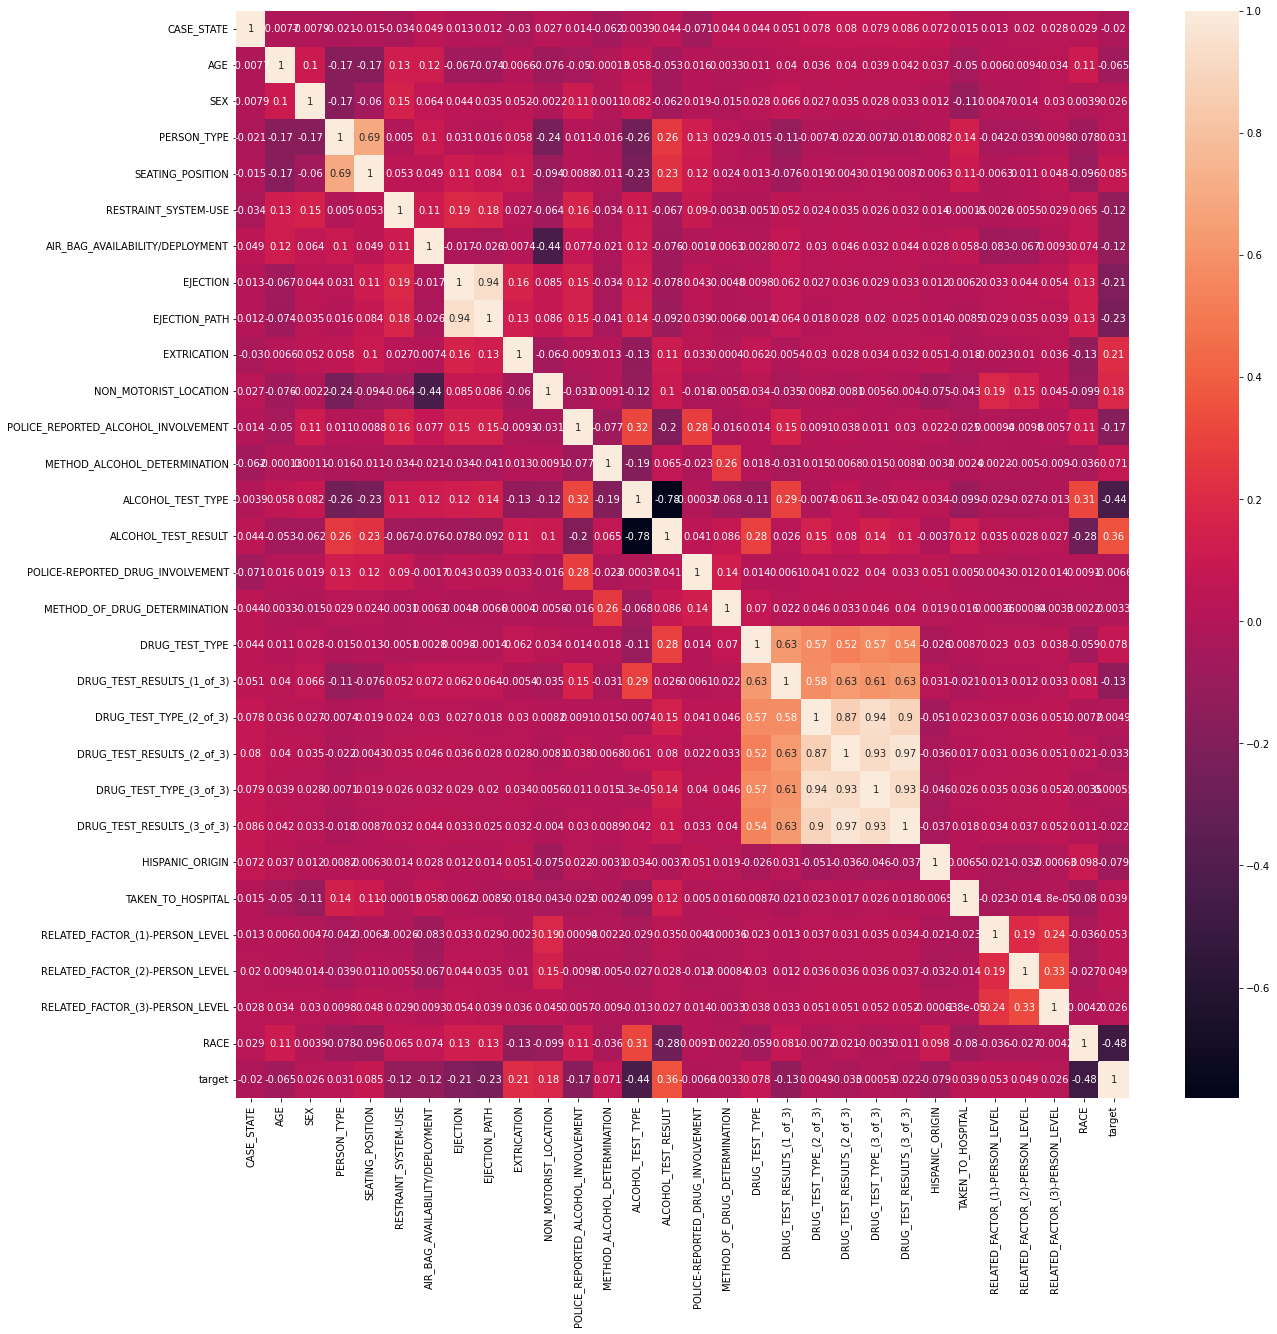

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

In [ ]:
### race and alcohol test type are coming biggest factor for high severity of accidents

 # Dataset 2: CIFARTile

### Data augmentation intro

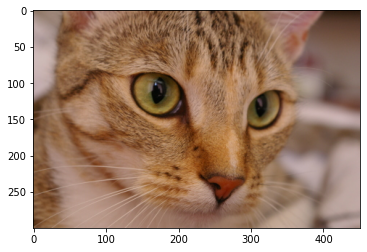

In [ ]:
from skimage import data

im = data.chelsea()

plt.imshow(im)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
rotation_range=25,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [ ]:
# im.shape

# x = x.reshape((1,) + (x.shape[2],) +(x.shape[0],) +(x.shape[1],) )
# x.shape

(300, 451, 3)

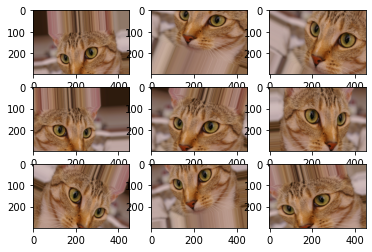

In [ ]:
def plot9(imageFlow):
  for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
  	# generate batch of images
    batch = imageFlow.next()
	  # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # add image to the set. We squeeze the image here as it may be a batch of images
    plt.imshow(np.squeeze(image))
  # display the 9 images
  plt.show()

im = im.reshape((1,) + im.shape)

img_iter = datagen.flow(im, batch_size=1)

plot9(img_iter)

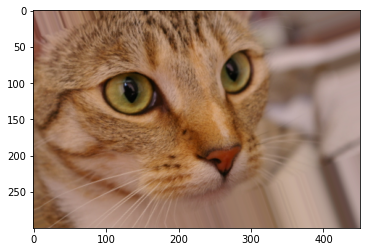

In [ ]:
im = data.chelsea()
im = im.reshape((1,) + im.shape)


datagen=ImageDataGenerator(rotation_range=20)
iter=datagen.flow(im,batch_size=2)
batch=iter.next()
plt.imshow(batch[0].astype('uint8'))

In [ ]:
batch.shape

(1, 300, 451, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_X = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/train_x.npy", allow_pickle=True)

In [ ]:
train_y = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/train_y.npy", allow_pickle=True)

In [ ]:
validate_X = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/valid_x.npy", allow_pickle=True)

In [ ]:
validate_y = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/valid_y.npy", allow_pickle=True)

In [ ]:
test_X = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/test_x.npy", allow_pickle=True)

In [ ]:
test_y = np.load("/content/drive/MyDrive/ML_coursework_CIFARTile_data/test_y.npy", allow_pickle=True)

## Example image

In [ ]:

def image_normalization(arr):
    return (arr - arr.min())/(arr.max()-arr.min())

def disable_ax_ticks(ax):
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def show_example(x, y):
    fig = plt.figure()
    main_ax = fig.add_subplot()
    fig.suptitle('label = '+ str(y))
    main_ax.imshow(image_normalization(np.moveaxis(x, 0, -1)))
    disable_ax_ticks(main_ax)

    plt.show()

In [ ]:
import random

count = train_X.shape[0]

ri = random.randrange(count)
show_example(train_X[ri], train_y[ri])

In [ ]:
unq, counts = np.unique(train_y, return_counts= True)
print(np.asarray((unq, counts)).T)

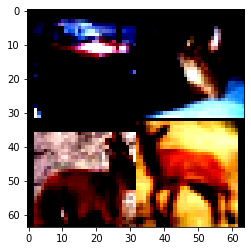

In [ ]:
fig = plt.figure()
m = fig.add_subplot()
m.imshow(np.moveaxis(train_X[50],0,-1))






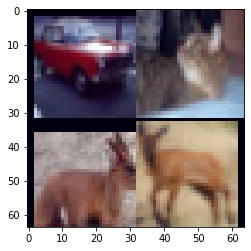

In [ ]:
def image_normalization(arr):
    return (arr - arr.min())/(arr.max()-arr.min())
fig = plt.figure()
m = fig.add_subplot()
m.imshow(image_normalization(np.moveaxis(train_X[50],0,-1)))


In [ ]:
train_X[50].max()

2.1267905

Sample classes looks equally distributed

In [ ]:
train_X.shape

(45000, 3, 64, 64)

In [ ]:
train_nsample, train_nrgb, train_nx,train_ny = train_X.shape

In [ ]:
train_X2 = train_X.reshape(train_nsample, train_nrgb*train_nx*train_ny)

In [ ]:
test_nsample, test_nrgb, test_nx,test_ny = test_X.shape

In [ ]:
test_X2 = test_X.reshape(test_nsample, test_nrgb*test_nx*test_ny)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()  
rf_clf.fit(train_X2[0:1000,:],train_y[0:1000])
score = rf_clf.score(train_X2[0:1000,:], train_y[0:1000])
print(score)

In [ ]:
test_score = rf_clf.score(test_X2, test_y)
print(test_score)

CV optimising

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [100,200, 500],
    'max_depth' : [3,5,7],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, verbose = 2)
rf_clf.fit(train_X2[0:1000,:],train_y[0:1000])

# print best parameter after tuning
print(rf_clf.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(rf_clf.best_estimator_)


In [ ]:
rf_clf

In [ ]:
pred = rf_clf.predict(test_X2)

In [ ]:
rf_clf.score(test_X2,test_y)

In [ ]:
rf2 = RandomForestClassifier(n_estimators =100, max_depth=7, max_features='log2')
rf2.fit(train_X2,train_y)

rf2.score(test_X2,test_y)

optimised accuracy on test set = 28.97%

# SVM model

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(train_X2[0:5000,:], train_y[0:5000])

SVC()

In [ ]:
svm_clf.score(train_X2[0:5000,:], train_y[0:5000])

0.8392

In [ ]:
svm_clf.score(test_X2, test_y)

0.2828

# CNN model for classification

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
#train_X /= 255
train_X.shape

(45000, 3, 64, 64)

In [ ]:
train_X = image_normalization(train_X)
validate_X = image_normalization(validate_X)
test_X = image_normalization(test_X)

In [ ]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = True

In [ ]:
train_y = keras.utils.to_categorical(train_y, num_classes)
validate_y = keras.utils.to_categorical(validate_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_X.shape[1:], data_format='channels_first'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 64, 64)        896       
                                                                 
 activation (Activation)     (None, 32, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 62, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 30, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 31, 32)        0         
                                                        

# ERROR |  ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d
### https://stackoverflow.com/questions/72413321/valueerror-one-of-the-dimensions-in-the-output-is-0-due-to-downsampling-in-c/72742906

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
validate_X.shape

(15000, 3, 64, 64)

In [ ]:
batch_size = 32
###########################################
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(train_X, train_y,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(validate_X, validate_y),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_X)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(train_X, train_y,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(validate_X,validate_y),
                                    workers=4)

Using real-time data augmentation.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1874: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 64, 64) (64 channels).
  warnings.warn('Expected input to be images (as Numpy array) '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:680: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 64, 64) (64 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
<ipython-input-24-24625c4496d4>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(train_X, t

Epoch 1/100


InvalidArgumentError: ignored

In [ ]:
pred = model.predict(test_X)

In [ ]:
scores = model.evaluate(test_X, test_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

NameError: ignored

Epoch 95/100
313/313 [==============================] - 5s 14ms/step - loss: 0.7692 - accuracy: 0.6927 - val_loss: 1.5744 - val_accuracy: 0.2856

Epoch 96/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7678 - accuracy: 0.6951 - val_loss: 1.6140 - val_accuracy: 0.2910

Epoch 97/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7639 - accuracy: 0.6998 - val_loss: 1.5469 - val_accuracy: 0.2825

Epoch 98/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7550 - accuracy: 0.7037 - val_loss: 1.5854 - val_accuracy: 0.2806

Epoch 99/100
313/313 [==============================] - 5s 14ms/step - loss: 0.7414 - accuracy: 0.7056 - val_loss: 1.6917 - val_accuracy: 0.2838

Epoch 100/100
313/313 [==============================] - 5s 14ms/step - loss: 0.7398 - accuracy: 0.7092 - val_loss: 1.6005 - val_accuracy: 0.2835

Test loss: 1.6726701259613037 Test accuracy: 0.2858999967575073


>>2 ON FIRST 2 CONV layer of 64 64 i am getting last epoch accuracy of 45 val_acc 29  || test accuracy 31%


>>3 learning rate 0.001 instead 0.0001 | 51 accuracy, val  acc 28 % | test accuracy 29.3%

>>4 WITH DATA AUGMENTATION, batch_size = 100, train_x[10,000], val5000

Epoch 98/100
100/100 [==============================] - 49s 472ms/step - loss: 1.3358 - accuracy: 0.3438 - val_loss: 1.3914 - val_accuracy: 0.3138

Epoch 99/100
100/100 [==============================] - 49s 475ms/step - loss: 1.3325 - accuracy: 0.3460 - val_loss: 1.3666 - val_accuracy: 0.3080

Epoch 100/100
100/100 [==============================] - 50s 470ms/step - loss: 1.3325 - accuracy: 0.3500 - val_loss: 1.3597 - val_accuracy: 0.3166

Test loss: 1.3803764581680298
Test accuracy: 0.30809998512268066

# 3 Tweets text analysis| Sentiment

In [ ]:
# nltk
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/Tweets_train.csv')
df_val = pd.read_csv('/content/Tweets_dev.csv')
df_test = pd.read_csv('/content/Tweets_test (1).csv', encoding='latin-1')

In [ ]:
df_train.head()

tweet_id                                               text  \
0  569179849518161920                    @united you're good. Thank you!   
1  569835751275433984  @AmericanAir way to ruin a vacation, my brothe...   
2  568588936852799488  @JetBlue yes thankfully! Catering just got her...   
3  569525116725567491  @USAirways The automated message isn't helpful...   
4  568807823187976193  @JetBlue I'm #MakingLoveOutofNothingAtAll on m...   

  airline_sentiment  
0          positive  
1          negative  
2          positive  
3          negative  
4          positive

In [ ]:
df_train.iloc[11377,1]

'@SouthwestAir is this a joke? My return flight is delayed too! 3 in a row! New record from you guys 💔😪'

In [ ]:
df_train.iloc[4,1]

"@JetBlue I'm #MakingLoveOutofNothingAtAll on my #brandloveaffair to #LAX https://t.co/kdHRUF54sW"

In [ ]:
df_train['airline_sentiment'].value_counts()

negative    7434
neutral     2510
positive    1914
Name: airline_sentiment, dtype: int64

## Cleaning username and url 

In [ ]:
import re
def cleaning_URLs(data):
  data = re.sub('@[^\s]+','',data)
  return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', data)


df_train['text'] = df_train['text'].apply(lambda x: cleaning_URLs(x))
df_val['text'] = df_val['text'].apply(lambda x: cleaning_URLs(x))
df_test['text'] = df_test['text'].apply(lambda x: cleaning_URLs(x))


In [ ]:
df_train.iloc[4,1]

" I'm #MakingLoveOutofNothingAtAll on my #brandloveaffair to #LAX "

## Handling contractions

In [ ]:
CONTRACTIONS =  {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }


def expanding_contractions(text):
  text = text.replace("’","'")
  
  return ' '.join([CONTRACTIONS[word] if word in CONTRACTIONS else word for word in str(text).split()])
df_train['text'] = df_train['text'].apply(lambda text: expanding_contractions(text))
df_test['text'] = df_test['text'].apply(lambda text: expanding_contractions(text))
df_val['text'] = df_val['text'].apply(lambda text: expanding_contractions(text))

df_train['text']

# df_train['text'] = df_train['text'].replace("’","'")
# #f = lambda x: (x['text'].split()) 
# #" ".join([word for word in str(text).split() if word not in STOPWORDS])
# words = str(df_train['text']).split()
# #words = df_train['text']
# tweet = ' '.join([CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words])
# #tweet = " ".join(reformed)
# tweet

0                                 you are good. Thank you!
1        way to ruin a vacation, my brother has called ...
2        yes thankfully! Catering just got here and now...
3        The automated message is not helpful and it is...
4        I am #MakingLoveOutofNothingAtAll on my #brand...
                               ...                        
11853    will not help us on the phone, at the gate or ...
11854    has the worst customer service line. I have ca...
11855    grades for this trip: Flight timeliness: 👎✈️ C...
11856    Thanks for the vague canned response that does...
11857    already did that at the airport and 12 hrs Lat...
Name: text, Length: 11858, dtype: object

In [ ]:
df_train

tweet_id                                               text  \
0      569179849518161920                           you are good. Thank you!   
1      569835751275433984  way to ruin a vacation, my brother has called ...   
2      568588936852799488  yes thankfully! Catering just got here and now...   
3      569525116725567491  The automated message is not helpful and it is...   
4      568807823187976193  I am #MakingLoveOutofNothingAtAll on my #brand...   
...                   ...                                                ...   
11853  570123872168574976  will not help us on the phone, at the gate or ...   
11854  570063683256242177  has the worst customer service line. I have ca...   
11855  568032524749942784  grades for this trip: Flight timeliness: 👎✈️ C...   
11856  569705813142409217  Thanks for the vague canned response that does...   
11857  569976114124349440  already did that at the airport and 12 hrs Lat...   

      airline_sentiment  
0              positive  
1              negative  
2              positive  
3              negative  
4              positive  
...                 ...  
11853          negative  
11854          negative  
11855          negative  
11856          negative  
11857          negative  

[11858 rows x 3 columns]

## Cleaning emojis

In [ ]:
!pip install emoji
import emoji

def convert_emoji(txt):
  tweet = emoji.demojize(txt)
  tweet = tweet.replace(":"," ")
  tweet = ' '.join(tweet.split())

  return(tweet)

for i in range(len(df_train['text'])):
  text = df_train.iloc[i,1]
  text = convert_emoji(text)
  df_train.iloc[i,1] = text

for i in range(len(df_val['text'])):
  text = df_val.iloc[i,1]
  text = convert_emoji(text)
  df_val.iloc[i,1] = text

for i in range(len(df_test['text'])):
  text = df_test.iloc[i,1]
  text = convert_emoji(text)
  df_test.iloc[i,1] = text

df_train.iloc[11377,1]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'is this a joke? My return flight is delayed too! 3 in a row! New record from you guys broken_heart sleepy_face'

## Do some EDA

## Preprocessing

In [ ]:
df_train.iloc[4,1]
df_train['text'][4]

'I am #MakingLoveOutofNothingAtAll on my #brandloveaffair to #LAX'

In [ ]:
data_train =df_train[['text', 'airline_sentiment']].copy()
data_val = df_val[['text', 'airline_sentiment']].copy()
data_test = df_test[['text', 'airline_sentiment']].copy()

In [ ]:
data_train

text airline_sentiment
0                               you are good. Thank you!          positive
1      way to ruin a vacation, my brother has called ...          negative
2      yes thankfully! Catering just got here and now...          positive
3      The automated message is not helpful and it is...          negative
4      I am #MakingLoveOutofNothingAtAll on my #brand...          positive
...                                                  ...               ...
11853  will not help us on the phone, at the gate or ...          negative
11854  has the worst customer service line. I have ca...          negative
11855  grades for this trip Flight timeliness thumbs_...          negative
11856  Thanks for the vague canned response that does...          negative
11857  already did that at the airport and 12 hrs Lat...          negative

[11858 rows x 2 columns]

In [ ]:
data_train.rename(columns= {'airline_sentiment':'target'}, inplace=True)
data_val.rename(columns= {'airline_sentiment':'target'}, inplace=True)
data_test.rename(columns= {'airline_sentiment':'target'}, inplace=True)

In [ ]:
data_train['target'] = data_train['target'].map({'negative':0,'neutral':1,'positive':2})
data_val['target'] = data_val['target'].map({'negative':0,'neutral':1,'positive':2})
data_test['target'] = data_test['target'].map({'negative':0,'neutral':1,'positive':2})

In [ ]:
data_val['target'].value_counts()

0    826
1    279
2    213
Name: target, dtype: int64

In [ ]:
data_train['text'] = data_train['text'].str.lower()
data_val['text'] = data_val['text'].str.lower()
data_test['text'] = data_test['text'].str.lower()

In [ ]:
data_train['text']

0                                 you are good. thank you!
1        way to ruin a vacation, my brother has called ...
2        yes thankfully! catering just got here and now...
3        the automated message is not helpful and it is...
4        i am #makingloveoutofnothingatall on my #brand...
                               ...                        
11853    will not help us on the phone, at the gate or ...
11854    has the worst customer service line. i have ca...
11855    grades for this trip flight timeliness thumbs_...
11856    thanks for the vague canned response that does...
11857    already did that at the airport and 12 hrs lat...
Name: text, Length: 11858, dtype: object

## Stopwords

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_train['text'] = data_train['text'].apply(lambda text: cleaning_stopwords(text))
data_val['text'] = data_val['text'].apply(lambda text: cleaning_stopwords(text))
data_test['text'] = data_test['text'].apply(lambda text: cleaning_stopwords(text))

data_train['text'].head()

0                                     good. thank you!
1    way ruin vacation, brother called night multip...
2    yes thankfully! catering got loading, but frus...
3    automated message not helpful impossible speak...
4    #makingloveoutofnothingatall #brandloveaffair ...
Name: text, dtype: object

## cleaning punctuations

In [ ]:
import string
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data_train['text'] = data_train['text'].apply(lambda x: cleaning_punctuations(x))
data_val['text'] = data_val['text'].apply(lambda x: cleaning_punctuations(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_punctuations(x))

data_train['text'].head()
# data_train
# data_val
# data_test

0                                       good thank you
1    way ruin vacation brother called night multipl...
2    yes thankfully catering got loading but frustr...
3    automated message not helpful impossible speak...
4      makingloveoutofnothingatall brandloveaffair lax
Name: text, dtype: object

In [ ]:
data_train.iloc[11377,0]
data_train.iloc[4,0]

'makingloveoutofnothingatall brandloveaffair lax'

## cleaning repeating characters

In [ ]:
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_train['text'] = data_train['text'].apply(lambda x: cleaning_repeating_char(x))
data_val['text'] = data_val['text'].apply(lambda x: cleaning_repeating_char(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_repeating_char(x))
data_train['text'].head()

0                                       good thank you
1    way ruin vacation brother called night multipl...
2    yes thankfully catering got loading but frustr...
3    automated message not helpful impossible speak...
4      makingloveoutofnothingatall brandloveaffair lax
Name: text, dtype: object

In [ ]:
# removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_train['text'] = data_train['text'].apply(lambda x: cleaning_numbers(x))
data_val['text'] = data_val['text'].apply(lambda x: cleaning_numbers(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_numbers(x))

data_train.head()

text  target
0                                     good thank you       2
1  way ruin vacation brother called night multipl...       0
2  yes thankfully catering got loading but frustr...       2
3  automated message not helpful impossible speak...       0
4    makingloveoutofnothingatall brandloveaffair lax       2

## tokenization

In [ ]:


from nltk.tokenize import word_tokenize

data_train['text'] = data_train['text'].apply(word_tokenize)
data_val['text'] = data_val['text'].apply(word_tokenize)
data_test['text'] = data_test['text'].apply(word_tokenize)

data_train.head()

text  target
0                                 [good, thank, you]       2
1  [way, ruin, vacation, brother, called, night, ...       0
2  [yes, thankfully, catering, got, loading, but,...       2
3  [automated, message, not, helpful, impossible,...       0
4  [makingloveoutofnothingatall, brandloveaffair,...       2

## stemming

In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_train['text'] = data_train['text'].apply(lambda x: stemming_on_text(x))
data_val['text'] = data_val['text'].apply(lambda x: stemming_on_text(x))
data_test['text'] = data_test['text'].apply(lambda x: stemming_on_text(x))

data_train.head()

text  target
0                                 [good, thank, you]       2
1  [way, ruin, vacation, brother, called, night, ...       0
2  [yes, thankfully, catering, got, loading, but,...       2
3  [automated, message, not, helpful, impossible,...       0
4  [makingloveoutofnothingatall, brandloveaffair,...       2

In [ ]:
# Lemmatizing
nltk.download('wordnet')
nltk.download('omw-1.4')

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_train['text'] = data_train['text'].apply(lambda x: lemmatizer_on_text(x))
data_val['text'] = data_val['text'].apply(lambda x: lemmatizer_on_text(x))
data_test['text'] = data_test['text'].apply(lambda x: lemmatizer_on_text(x))

data_train.head()
data_test.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


text  target
0                                     [need, refund]       0
1  [cancelled, flightlations, delay, causing, mis...       0
2              [thanks, much, cant, wait, fly, guys]       2
3  [never, frustrated, conversations, united, can...       0
4  [worst, hold, time, crazy, agents, horrible, n...       0

In [ ]:
# Splitting train data

X_train = data_train.text
y_train = data_train.target


X_val = data_val.text
y_val = data_val.target

X_test = data_test.text
y_test = data_test.target

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(11858,)
(11858,)
(1318,)
(1318,)
(1464,)
(1464,)


In [ ]:
words = all_data.astype('string')  #converting series into words
words

NameError: ignored

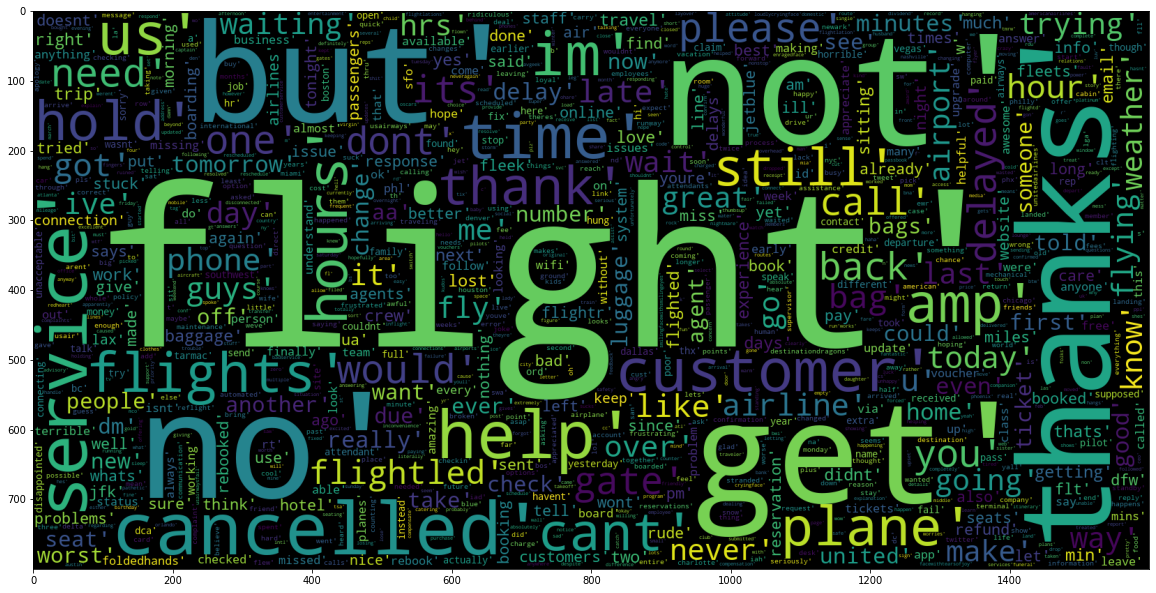

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(words))
plt.imshow(wc)

## Transforming Dataset using TF-IDF Vectorizer

In [ ]:
## why we are doing this, because of the error ' AttributeError: 'list' object has no attribute 'lower'
#  while vectorizing it in next steps

# soln : https://stackoverflow.com/questions/45883679/train-model-fails-because-list-object-has-no-attribute-lower
# The TFIDF Vectorizer should expect an array of strings. So if you pass it an array of arrays of tokenz, it crashes.

X_train = X_train.apply(lambda x: ' '.join(x))
X_train.head()
X_test = X_test.apply(lambda x: ' '.join(x))
X_val = X_val.apply(lambda x: ' '.join(x))

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  81092


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vectoriser.get_feature_names()

['aa',
 'aa abidfw',
 'aa able',
 'aa advantage',
 'aa again',
 'aa agent',
 'aa air',
 'aa airline',
 'aa also',
 'aa amp',
 'aa and',
 'aa app',
 'aa around',
 'aa avoided',
 'aa award',
 'aa awesome',
 'aa bc',
 'aa botched',
 'aa but',
 'aa can',
 'aa cancelled',
 'aa changed',
 'aa considering',
 'aa cool',
 'aa credit',
 'aa cstmr',
 'aa customer',
 'aa dallas',
 'aa dart',
 'aa delayed',
 'aa delaypending',
 'aa departing',
 'aa desk',
 'aa detroit',
 'aa dfw',
 'aa did',
 'aa direct',
 'aa diverting',
 'aa does',
 'aa doesnt',
 'aa due',
 'aa elite',
 'aa email',
 'aa employee',
 'aa employees',
 'aa ever',
 'aa family',
 'aa fan',
 'aa feel',
 'aa flew',
 'aa flight',
 'aa flights',
 'aa future',
 'aa gate',
 'aa get',
 'aa going',
 'aa gold',
 'aa good',
 'aa got',
 'aa great',
 'aa help',
 'aa helping',
 'aa ignored',
 'aa incompetence',
 'aa ios',
 'aa jfk',
 'aa knew',
 'aa know',
 'aa kp',
 'aa lala',
 'aa lampf',
 'aa lax',
 'aa leave',
 'aa left',
 'aa let',
 'aa lgasat

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
X_val  = vectoriser.transform(X_val)

In [ ]:
X_train

<11858x81092 sparse matrix of type '<class 'numpy.float64'>'
	with 207901 stored elements in Compressed Sparse Row format>

In [ ]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)


BernoulliNB()

In [ ]:
y_pred = BNBmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       918
           1       0.83      0.06      0.11       310
           2       0.00      0.00      0.00       236

    accuracy                           0.64      1464
   macro avg       0.49      0.35      0.30      1464
weighted avg       0.57      0.64      0.51      1464



In [ ]:
# model 2

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = SVCmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       918
           1       0.70      0.51      0.59       310
           2       0.76      0.64      0.70       236

    accuracy                           0.81      1464
   macro avg       0.77      0.70      0.73      1464
weighted avg       0.80      0.81      0.79      1464



In [ ]:
# optimise SVM model 
# initial accuracy is 82 %

SVCmodel.score(X_test, y_test)

0.805327868852459

In [ ]:
## optimising SVClinear()

from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty' : ['l1', 'l2'],
    'multi_class' : ['ovr', 'crammer_singer'],
    'dual' : [True, False],
    'fit_intercept':[True, False],
    'C':[1.0,1.5,2.0]
    
}

SVCmodel = GridSearchCV(LinearSVC(),cv=5, param_grid = param_grid, verbose = 2)

SVCmodel.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total t

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.0, dual=True, fit

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.6s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.5s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.5s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.5s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.6s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.0, dual=False, f

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.6s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.6s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.2s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=1.5, dual=True, fit_interc

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.8s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.1s
[CV] END C=1.5, dual=True, fit

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.9s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual=False, f

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.7s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.7s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.6s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.7s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=1.5, dual

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.5, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.4s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.3s
[CV] END C=2.0, dual=True, fit_interc

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.1s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.2s
[CV] END C=2.0, dual=True, fit

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=True, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.7s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   1.2s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   1.1s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   1.0s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   1.0s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l1; total time=   1.2s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.6s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.6s
[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=ovr, penalty=l2; total time=   0.6s
[CV] END C=2.0, dual=False, f

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l1; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=True, multi_class=crammer_singer, penalty=l2; total time=   1.5s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   1.0s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.8s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l1; total time=   1.6s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s
[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=ovr, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.3s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.4s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblin

[CV] END C=2.0, dual=False, fit_intercept=False, multi_class=crammer_singer, penalty=l2; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [1.0, 1.5, 2.0], 'dual': [True, False],
                         'fit_intercept': [True, False],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [ ]:
SVCmodel.best_params_

{'C': 1.0,
 'dual': True,
 'fit_intercept': True,
 'multi_class': 'crammer_singer',
 'penalty': 'l1'}

In [ ]:
SVCmodel.best_estimator_

LinearSVC(multi_class='crammer_singer', penalty='l1')

In [ ]:
SVCmodel.score(X_test,y_test)

0.8094262295081968

In [ ]:
# SVM non linear
sb = SVC()
sb.fit(X_train,y_train)

SVC()

In [ ]:
sb.score(X_test,y_test)

0.773224043715847

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [ 1, 100, 1000],
              'gamma': [0.1, 0.001, 0.0001],
              'kernel': ['rbf','poly','sigmoid']}
 
svm_clf = GridSearchCV(SVC(),cv=5, param_grid = param_grid, verbose = 2)
 
# fitting the model for grid search
svm_clf.fit(X_train, y_train)

# print best parameter after tuning
print(svm_clf.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(svm_clf.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  18.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  17.3s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  17.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  17.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  17.5s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  11.2s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  11.2s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  11.2s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  11.3s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  11.7s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=  15.7s
[CV] END .....................C=1, gamma=0.1, k

In [ ]:
svm_clf.score(X_test, y_test)

0.805327868852459

## Decision tree classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTclf_model = DecisionTreeClassifier(criterion="gini", random_state=1,max_depth=5, min_samples_leaf=1)   
DTclf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [ ]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.6784
Accuracy of Decision tree classifier on test set: 0.6769


In [ ]:
# optimising decision tree

# earlier best model was : DecisionTreeClassifier(max_depth=13, max_leaf_nodes=40, min_samples_split=6)

from sklearn.model_selection import GridSearchCV

parameters = {'max_leaf_nodes': [5, 10, 25, 40], 
          'min_samples_split': [5, 6, 8],
          'max_depth':[8,10,13,15]}

DTclf_model = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv= 5, verbose = 2, return_train_score = True)
DTclf_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=5; total time=   4.4s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=5; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=5; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=5; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=5; total time=   4.2s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=6; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=6; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=6; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=6; total time=   4.2s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=6; total time=   4.2s
[CV] END .max_depth=8, max_leaf_nodes=5, min_samples_split=8; total time=   4.3s
[CV] END .max_depth=8, max_leaf_nodes=5, min_sa

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [8, 10, 13, 15],
                         'max_leaf_nodes': [5, 10, 25, 40],
                         'min_samples_split': [5, 6, 8]},
             return_train_score=True, verbose=2)

In [ ]:
DTclf_model.best_score_

0.6944688240352261

In [ ]:
DTclf_model.best_estimator_

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=40, min_samples_split=8)

In [ ]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.7039
Accuracy of Decision tree classifier on test set: 0.6933


Test accuracy increased from 62 to 67.9%

## Deep learning

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

ImportError: ignored

In [ ]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing import sequence

In [ ]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

In [ ]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
          verbose=2,
          validation_data=(X_val, y_val))

# Dataset 4| Weather time series data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weather_data = pd.read_csv("/content/drive/MyDrive/ML_coursework_weather_data/weather.csv")

In [ ]:
weather_data.iloc[:,0]

0         Wed 17 Nov 2021 03:21:02 PM GMT
1         Wed 17 Nov 2021 03:22:03 PM GMT
2         Wed 17 Nov 2021 03:23:05 PM GMT
3         Wed 17 Nov 2021 03:24:02 PM GMT
4         Wed 17 Nov 2021 03:25:03 PM GMT
                       ...               
545431    Thu 01 Dec 2022 09:58:02 AM GMT
545432    Thu 01 Dec 2022 09:59:03 AM GMT
545433    Thu 01 Dec 2022 10:00:02 AM GMT
545434    Thu 01 Dec 2022 10:01:03 AM GMT
545435    Thu 01 Dec 2022 10:02:02 AM GMT
Name: Wed 17 Nov 2021 03:20:03 PM GMT, Length: 545436, dtype: object

In [ ]:
weather_data.iloc[311425,0]

'Tue 21 Jun 2022 10:46:03 PM BST'

In [ ]:
import dateutil.parser
import dateutil.tz

# BST time is not defined, so replacing it with UTC-1 and then converting column to datetime object

weather_data.iloc[:,0] = weather_data.iloc[:,0].replace('BST','UTC-1', regex=True)
#BST = dateutil.tz.gettz('Europe/London')
#    local = dateutil.parser.parse(bst_time.iloc[i,0], tzinfos={'BST': BST})
#    bst_to_utc.append(local.astimezone(dateutil.tz.UTC))     ,tzinfos={'BST': dateutil.tz.gettz('Europe/London')
#    parse_dates=[0],date_parser=lambda col: pd.to_datetime(col, utc=True

In [ ]:
weather_data.iloc[:,0] =  pd.to_datetime(weather_data.iloc[:,0], utc = True)

In [ ]:
df_outTemp = weather_data.iloc[:,[0,2]].copy()

In [ ]:
df_outTemp.columns = ['Time','Outside temperature']
df_outTemp.head()

Time  Outside temperature
0 2021-11-17 15:21:02+00:00                  9.8
1 2021-11-17 15:22:03+00:00                  9.8
2 2021-11-17 15:23:05+00:00                  9.8
3 2021-11-17 15:24:02+00:00                  9.8
4 2021-11-17 15:25:03+00:00                  9.8

ConversionError: ignored

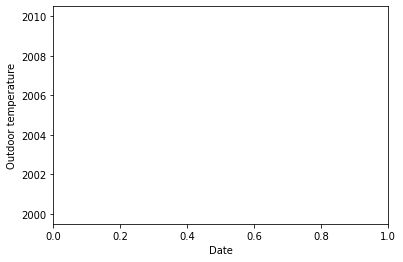

In [ ]:
plt.xlabel('Date')
plt.ylabel('Outdoor temperature')
plt.plot(df_outTemp)

In [ ]:
df_minutes = (df_outTemp.groupby([df_outTemp['Time'].dt.date, df_outTemp['Time'].dt.hour, df_outTemp['Time'].dt.minute])['Outside temperature']
            .sum()
            .unstack(fill_value=0))
print(df_minutes)

Time             0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
Time       Time                                                               
2021-11-17 15.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
           16.0   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   
           17.0   8.9   8.9   9.0   9.0   9.0   9.1   9.1   9.1   9.1   9.1   
           18.0   9.0   8.9   8.9   8.9   8.9   8.9   8.8   8.9   8.9   9.0   
           19.0   9.0   9.0   9.0   8.9   9.0   9.0   9.0   9.0   9.0   8.9   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-12-01 6.0    1.2   1.3   1.4   1.4   1.5   1.6   1.7   1.7   1.7   1.7   
           7.0    2.9   3.0   3.1   3.1   3.1   3.1   3.1   3.0   2.9   2.9   
           8.0    3.1   3.1   3.1   3.1   3.1   3.1   3.1   3.2   3.2   3.2   
           9.0    3.9   4.0   4.0   4.1   4.2   4.1   4.1   4.1   4.1   4.1   
           10.0   4.5   4.5   4.5   0.0   0.0   0.0 

In [ ]:
df_minutes.shape

(9092, 60)

In [ ]:
df_minutes.head()

Time             0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
Time       Time                                                               
2021-11-17 15.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
           16.0   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   8.6   
           17.0   8.9   8.9   9.0   9.0   9.0   9.1   9.1   9.1   9.1   9.1   
           18.0   9.0   8.9   8.9   8.9   8.9   8.9   8.8   8.9   8.9   9.0   
           19.0   9.0   9.0   9.0   8.9   9.0   9.0   9.0   9.0   9.0   8.9   

Time             ...  50.0  51.0  52.0  53.0  54.0  55.0  56.0  57.0  58.0  \
Time       Time  ...                                                         
2021-11-17 15.0  ...   9.4   9.4   9.2   9.1   9.1   8.9   8.8   8.6   8.6   
           16.0  ...   8.6   8.8   8.8   8.9   8.9   8.8   8.9   8.9   8.9   
           17.0  ...   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0   8.9   
           18.0  ...   8.9   8.9   8.6   8.7   8.7   8.8   8.7   8.8   9.0   
           19.0  ...   8.9   9.0   8.9   9.0   9.0   9.0   9.0   9.0   9.0   

Time             59.0  
Time       Time        
2021-11-17 15.0   8.6  
           16.0   9.0  
           17.0   8.9  
           18.0   9.0  
           19.0   9.1  

[5 rows x 60 columns]

<Figure size 2880x720 with 0 Axes>

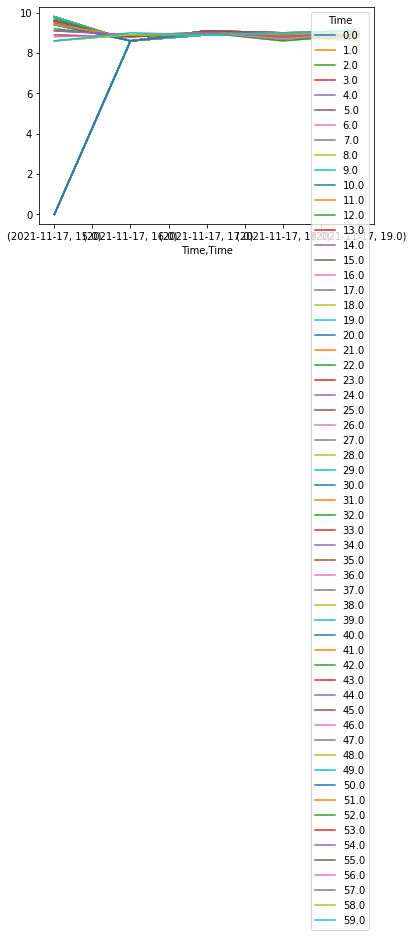

In [ ]:
#df_minutes.iloc[0:5,:].plot()

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
df_minutes.iloc[0:5,:].plot()

#plt.plot(df_minutes.iloc[0:10,:])

ConversionError: ignored

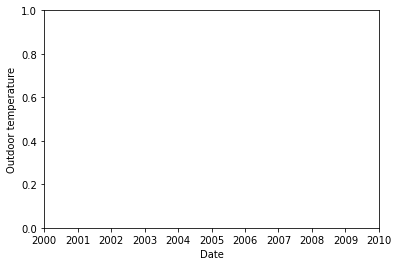

In [ ]:

plt.xlabel('Date')
plt.ylabel('Outdoor temperature')
plt.plot(df_minutes)

In [ ]:
df_outTemp.iloc[0:100,].plot()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f02faa8b160> (for post_execute):


ValueError: ignored

ValueError: ignored